In [ ]:
from scipy.stats import gamma, weibull_min, kstest
import numpy as np
import matplotlib.pyplot as plt

Firstly, let's demonstrate why K-S tests is not reliable when the null distribution parameters are estimated for the Gamma(0, 1) distribution. 

/var/folders/zg/k9cf63yd0k78jkv55v64d0y80000gn/T/ipykernel_57321/1652034655.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


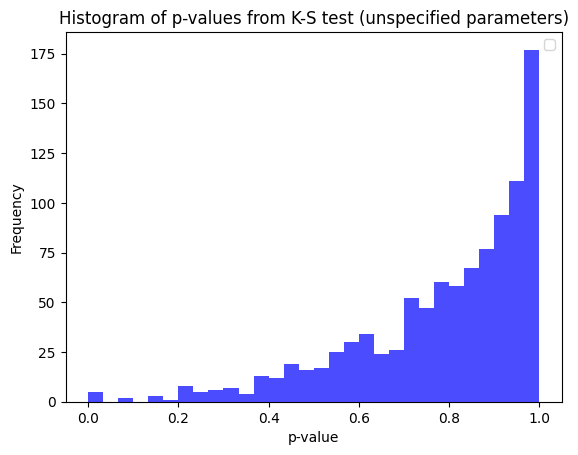

In [9]:
def weibull(x, alpha, beta):
    """Weibull probability density function."""
    assert alpha > 0 and beta > 0, "Shape and scale parameters must be positive."
    if x < 0:
        return 0.0
    return (alpha / beta) * (x / beta) ** (alpha - 1) * np.exp(-(x / beta) ** alpha)


SAMPLE_TRIALS = 1000
SAMPLE_SIZE = 100

misused_gamma_p_values = []

for i in range(SAMPLE_TRIALS):
    # Generate random samples from a gamma distribution
    data_gamma = gamma.rvs(a=2, size=SAMPLE_SIZE)

    # Estimate parameters for the Gamma distribution
    shape, loc, scale = gamma.fit(data_gamma)

    # Perform the K-S test against a Gamma distribution with estimated parameters
    d, p_value = kstest(data_gamma, 'gamma', args=(shape, loc, scale), N=len(data_gamma))
    # Store the p-value
    misused_gamma_p_values.append(p_value)

# histogram of p-values
plt.hist(misused_gamma_p_values, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of p-values from K-S test (unspecified parameters)')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The p-value should follow a uniform distribution (U(0, 1)) under the null hypothesis. However, when we estimate the parameters of the Gamma distribution from the data, the p-values do not follow a uniform distribution.

Now let's implement the algorithms from section 2 of the paper, namely:

To fix the problem, parametric bootstrap can be used to approximate the null distribution
of the testing statistic.
1. Draw a random sample $X_{1}^{*}, \dots, X_{n}^{*}$ from the fitted distribution $F_{\hatθ_n}$
2. Fit $F_{θ}$ to the sample and obtain estimated $\hatθ^{*}_{n}$
3. Obtain the empirical distribution function $F^{*}_{n}$ of $X^{*}_{1}, \dots, X^{*}_{n}$.
4. Calculate bootstrap KS statistic
$$D= \sup_{x} |F^{*}_{n}(x) - F^{*}_{\hatθ_{n}}(x)|.$$
5. Repeat the previous steps a large number $B$ times and use the empirical distribution
of $D^{*}$ to approximate the null distribution of the observed statistic.